# Introduction

This notebook will combine the satellite chlorophyll data downloaded in [`ChesapeakeBaySatellite.ipynb`]('notebooks/APIs/ChesapeakeBaySatellite.ipynb') with the buoy based weather data from [`data/buoy_aggregate.csv`]('../../data/buoy_aggregate.csv') in order to use the data in our model. It will also prepare the [`data/water_cleaned.csv`]('../data/water_cleaned.csv') data for the model.

In [6]:
import pandas as pd
import numpy as np
import io

import xarray as xr

import logging
from tqdm import tqdm  # For progress bar
# Configure logging instead of print
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Satelitte and buoy data

## Preparing the satellite data

We will read in the satellite data as an xarray. This data has coordinates

>Coordinates:
>  * x        (x)  
>  * y        (y)  
>  *  lat      (y, x) 
>  *  lon      (y, x) 
>  * time     (time) 
>  * level    (level) 

where `x` is projection_x_coordinate in meters, `y` is projection_y_coordinate in meters, `lat` is latitude, `lon` is longitude, `time` is a `datetime64` timestamp, and `level` is the height of the measurement from the surface. All `level` values are `0`, indicating surface measurements.

We do not need two set of location coordinates, so we will regrid the data to use `lat` and `lon` as the coordinate variables. This will match with the coordinates from our other datasets. We will also rename `level` to `depth`.

In [8]:
satellite_data = xr.open_dataset('../../data/combinedSatelitte_unmasked.nc4', engine='netcdf4')

satellite_data

OSError: [Errno -51] NetCDF: Unknown file format: '/Users/clairemerriman/Library/CloudStorage/GoogleDrive-clmerriman@davidson.edu/My Drive/ChesapeakeBay/data/combinedSatelitte_unmasked.nc4'

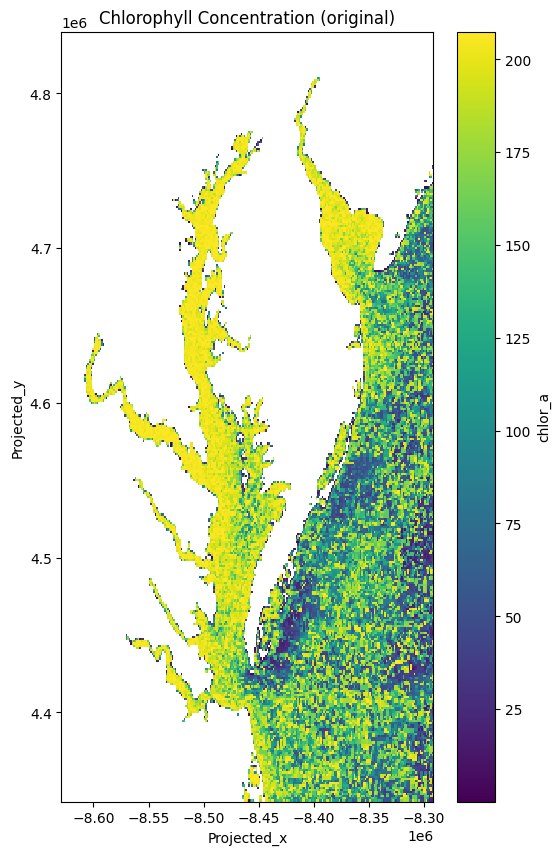

In [118]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data['chlor_a'].max(dim='time', skipna=True).isel(level=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (original)')
plt.xlabel('Projected_x')
plt.ylabel('Projected_y')

# Show the plot
plt.show()

In [125]:
# Extract the lat/lon coordinates
lon_coords = satellite_data['lon'].values  # Longitude coordinates
lat_coords = satellite_data['lat'].values  # Latitude coordinates

# Create a 2D grid from the 1D lat/lon arrays
# lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

: 

In [122]:
def xarray_select_variables(ds):
    
    latitude = ds['lat'].values
    longitude = ds['lon'].values

    spatial_dims = ('y', 'x')
    
    # Stack the 'chlor_a' variable based on detected spatial dimensions and get the flattened array
    var_flat = ds['chlor_a'].stack(spatial=spatial_dims).values


    # Remove duplicate lat/lon points to ensure unique lat/lon coordinates if needed
    lat_unique, lon_unique = np.unique(latitude)[::-1], np.unique(longitude)

    # Rename level
    ds = ds.rename({'level':'depth'})

    # Initialize the new dataset with reshaped data
    new_ds = xr.Dataset(
        {
            'chlor_a': (('time', 'depth', 'lat', 'lon'), var_flat.reshape(ds['time'].size, ds['depth'].size, len(lat_unique), len(lon_unique)))
        },
        coords={
            'time': ds['time'],
            'depth': ds['depth'],
            'lat': lat_unique,
            'lon': lon_unique
        }
    )

    # Step 6: Dynamically copy metadata for all data variables
    for var in ds.data_vars:
        # Check if the variable exists in the new dataset and copy metadata
        if var in new_ds.data_vars:
            new_ds[var].attrs = ds[var].attrs  # Copy the metadata dynamically

    # Step 7: Dynamically copy metadata for all coordinates (no hardcoding)
    for coord in ds.coords:
        # If the coordinate exists in the new dataset, copy metadata
        if coord in new_ds.coords:
            new_ds[coord].attrs = ds[coord].attrs

    new_ds['lat'].attrs = ds['lat'].attrs  # Copy longitude metadata

    new_ds['lon'].attrs = ds['lon'].attrs  # Copy longitude metadata

    new_ds.attrs = ds.attrs

    # Check the new dataset structure
    return new_ds


In [123]:
satellite_data_reindex= xarray_select_variables(satellite_data)
satellite_data_reindex

<xarray.Dataset> Size: 963MB
Dimensions:  (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time     (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-10-30T17...
  * depth    (depth) float64 8B 0.0
  * lat      (lat) float64 3kB 36.49 36.5 36.51 36.52 ... 39.98 39.99 40.0 40.01
  * lon      (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a  (time, depth, lat, lon) float32 963MB nan nan nan ... 0.2937 0.3537

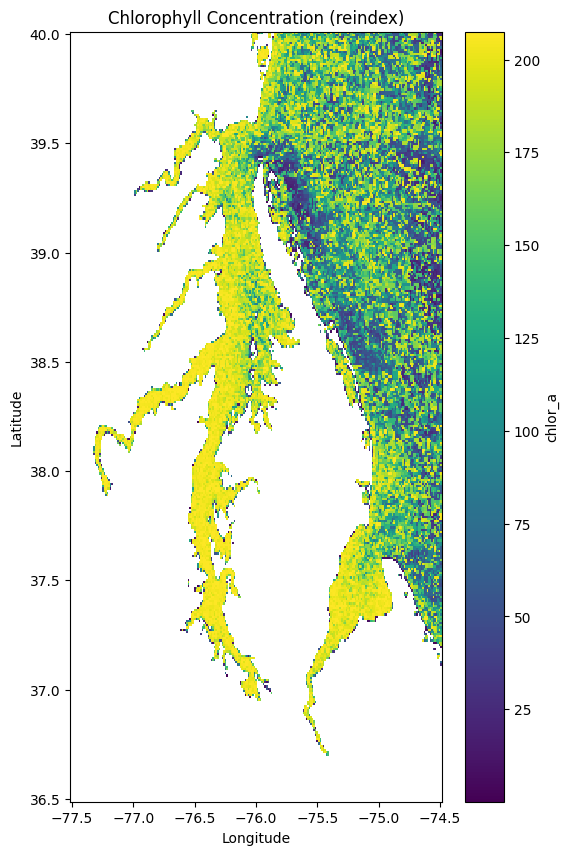

In [124]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data_reindex['chlor_a'].max(dim='time', skipna=True).isel(depth=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (reindex)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [68]:
for var in satellite_data_reindex.data_vars:
    data = satellite_data_reindex[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

Percentage of NaN values in 'chlor_a': 87.22%


## Preparing the buoy data

We will read in the buoy data, then create a dictionary that aggreates the data by day. This dictionary will save time when aligning with the satellite data, as the grouping csv rows takes time.

In [6]:
# Load buoy data from CSV
buoy_data = pd.read_csv('../../data/buoy_aggregate.csv')

buoy_data['Date'] = pd.to_datetime(buoy_data['Date'])
buoy_data.columns

Index(['Date', 'Latitude', 'Longitude', 'Air Temperature', 'Air pressure',
       'Humidity', 'Wind speed', 'Wind Direction'],
      dtype='object')

Now we need to group the rows by date so that we can merge with the corresponding satellite data.

In [7]:
def preprocess_dataframe_by_date(df):
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # Group DataFrame by date
    grouped_data = {date: group for date, group in df.groupby('Date')}
    return grouped_data

buoy_dates_dict = preprocess_dataframe_by_date(buoy_data)

## Combining into one xarray

We need to to add the variables from the buoy data to the satellite data. First, we will find the buoy data for the correct date. Then, for each location in the the xarray, we find the closest buoy and attach the daily mean measurement for each of the variables.

Since we already filtered the chlorophyll data to only the Chesapeake Bay, we will use `chlor_a` to create a mask.

In [22]:
def merge_and_clean_xarray(ds, grouped_data):
    try:
        
        # Define the variable with the date for the xarray
        for time_value in ds['time'].values:
            # Extract date for each time value
            date_value = pd.to_datetime(time_value, unit='s').date()

            if date_value not in grouped_data:
                raise ValueError(f"No matching rows found for date: {date_value}")

            df_filtered = grouped_data[date_value]

            # Define where to find latitude and longitude
            latitudes = ds['lat'].values
            longitudes = ds['lon'].values
            csv_lat = df_filtered['Latitude'].values
            csv_lon = df_filtered['Longitude'].values

            # Create a meshgrid for xarray latitudes and longitudes
            lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')  # Shape (274, 66)

            # Calculate the latitude and longitude differences
            lat_diffs = lat_grid[:, :, np.newaxis] - csv_lat[np.newaxis, np.newaxis, :]  # Shape (274, 66, num_buoys)
            lon_diffs = lon_grid[:, :, np.newaxis] - csv_lon[np.newaxis, np.newaxis, :]  # Shape (274, 66, num_buoys)

            # Calculate distances using the differences
            distances = np.sqrt(lat_diffs**2 + lon_diffs**2)  # Shape (274, 66, num_buoys)
            closest_indices = np.argmin(distances, axis=2)  # Find closest buoy for each latitude

            closest_data = {}
            for col in df_filtered.columns:
                if col not in ['Latitude', 'Longitude', 'Date']:
                    closest_data[col] = df_filtered[col].values[closest_indices]

            new_ds = ds.copy(deep=True)
            for col, values in closest_data.items():
                new_ds[col] = (('lat','lon'), values)  # Use 'lat' dimension for closest values

            return new_ds

    except Exception as e:
        raise RuntimeError(f"Error merging and cleaning xarray: {str(e)}")

In [23]:
merged_data = merge_and_clean_xarray(satellite_data_reindex,buoy_dates_dict)

In [24]:
# List of variables to expand
variables_to_expand = ['Air Temperature', 'Air pressure', 'Humidity', 'Wind speed', 'Wind Direction']

# Expand variables to have dimensions (time, depth, lat, lon)
for var in variables_to_expand:
    merged_data[var] = merged_data[var].expand_dims({'time': merged_data.time, 'depth': merged_data.depth})

In [25]:
merged_data

<xarray.Dataset> Size: 11GB
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 3kB 36.49 36.5 36.51 ... 39.99 40.0 40.01
  * lon              (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float32 963MB nan nan ... 0.3537
    Air Temperature  (time, depth, lat, lon) float64 2GB 25.28 25.28 ... 24.25
    Air pressure     (time, depth, lat, lon) float64 2GB 1.017e+03 ... 1.013e+03
    Humidity         (time, depth, lat, lon) float64 2GB 68.69 68.69 ... 74.22
    Wind speed       (time, depth, lat, lon) float64 2GB 2.767 2.767 ... 4.945
    Wind Direction   (time, depth, lat, lon) float64 2GB 241.7 241.7 ... 301.0

Statistics for chlor_a:
  Mean: 6.031139373779297
  Std: 15.821718215942383
  Min: 0.0
  Max: 207.48316955566406



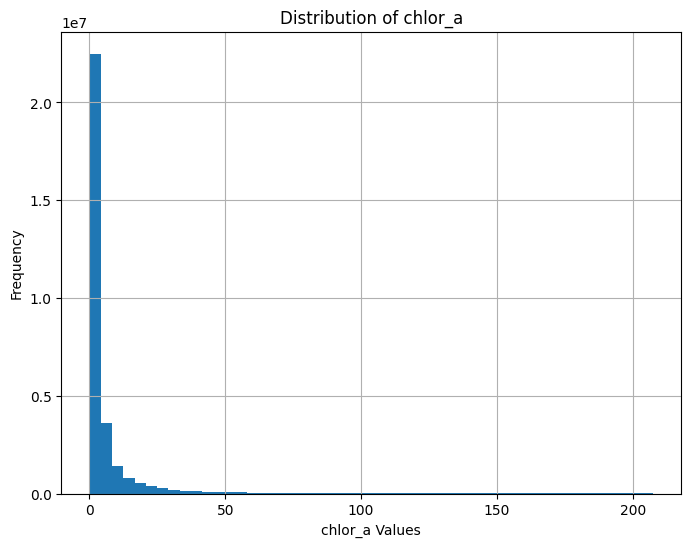

Statistics for Air Temperature:
  Mean: 25.314675869018693
  Std: 0.6517710919105126
  Min: 24.250694444444445
  Max: 26.33680555555556



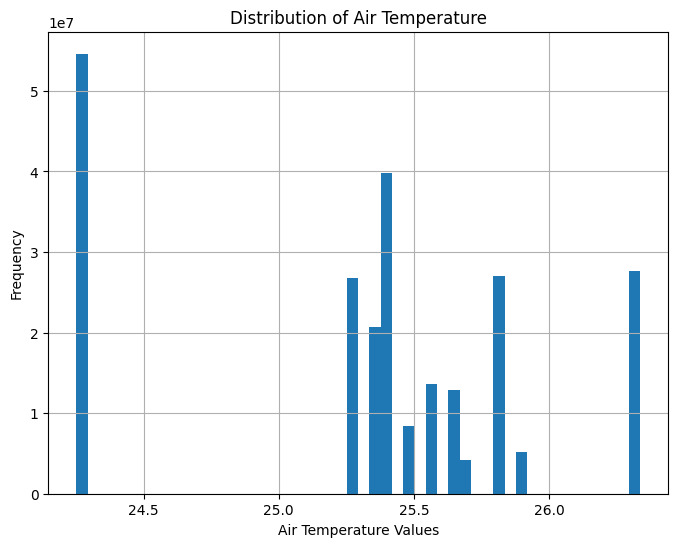

Statistics for Air pressure:
  Mean: 1013.7301263913671
  Std: 1.3846383680265617
  Min: 1011.73
  Max: 1017.2845138888888



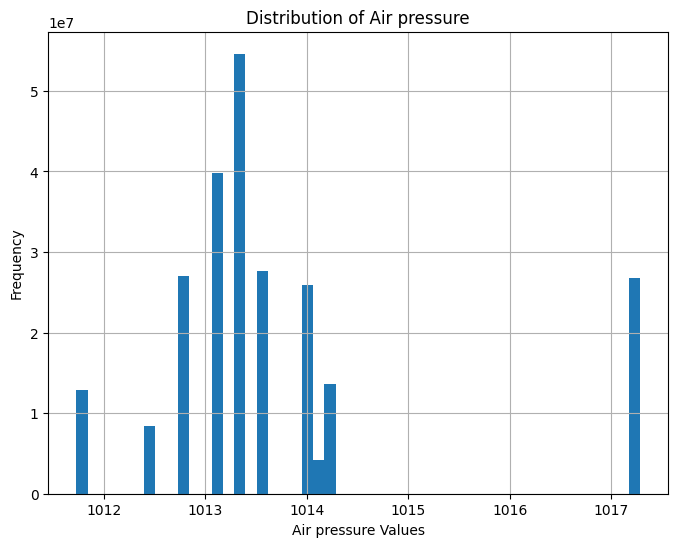

Statistics for Humidity:
  Mean: 76.84233088249954
  Std: 10.107623696156628
  Min: 64.3111111111111
  Max: 98.0326388888889



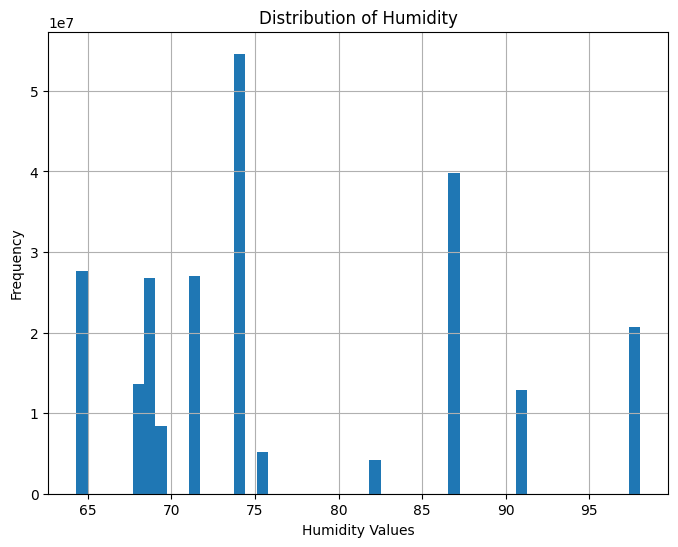

Statistics for Wind speed:
  Mean: 4.456363450853692
  Std: 1.0673430865196711
  Min: 2.0347222222222223
  Max: 6.858823529411764



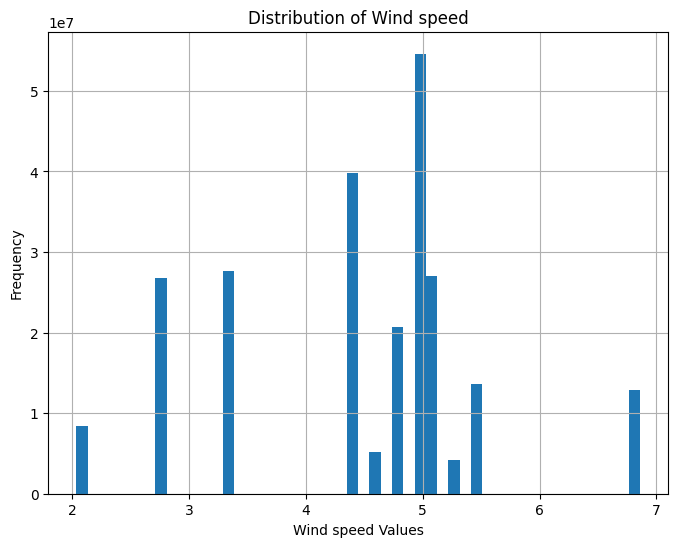

Statistics for Wind Direction:
  Mean: 251.7174530938097
  Std: 44.99092948165816
  Min: 139.81102362204723
  Max: 306.11764705882354



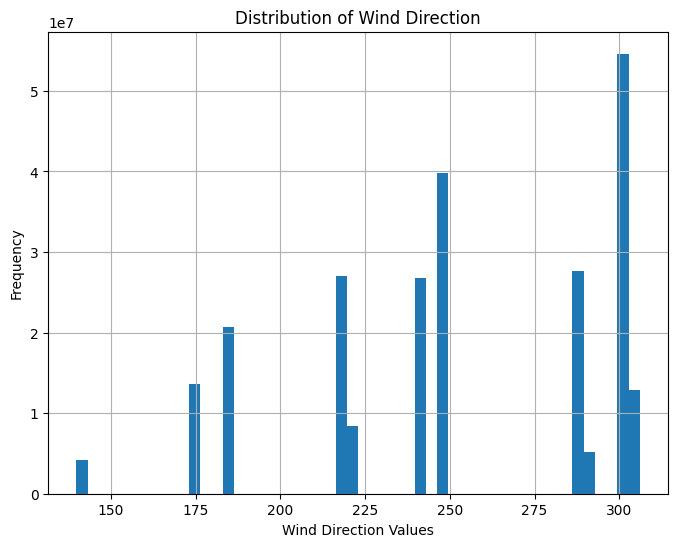

In [26]:
for var in merged_data.data_vars:
    # Compute mean, standard deviation, min, and max for each variable
    var_mean = merged_data[var].mean(dim=('time', 'depth', 'lat', 'lon'), skipna=True)
    var_std = merged_data[var].std(dim=('time', 'depth', 'lat', 'lon'), skipna=True)
    var_min = merged_data[var].min(dim=('time', 'depth', 'lat', 'lon'), skipna=True)
    var_max = merged_data[var].max(dim=('time', 'depth', 'lat', 'lon'), skipna=True)
    
    # Print statistics for each variable
    print(f"Statistics for {var}:")
    print(f"  Mean: {var_mean.values}")
    print(f"  Std: {var_std.values}")
    print(f"  Min: {var_min.values}")
    print(f"  Max: {var_max.values}\n")
    # Plot histogram for each variable
    plt.figure(figsize=(8, 6))
    merged_data[var].plot.hist(bins=50)
    plt.title(f'Distribution of {var}')
    plt.xlabel(f'{var} Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [69]:
for var in merged_data.data_vars:
    data = merged_data[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

Percentage of NaN values in 'chlor_a': 87.22%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Humidity': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values in 'Wind Direction': 0.00%
Percentage of NaN values in 'Wind_Direction_rad': 0.00%
Percentage of NaN values in 'Wind_Direction_sin': 0.00%
Percentage of NaN values in 'Wind_Direction_cos': 0.00%
Percentage of NaN values in 'Wind_Direction_interp_rad': 0.00%


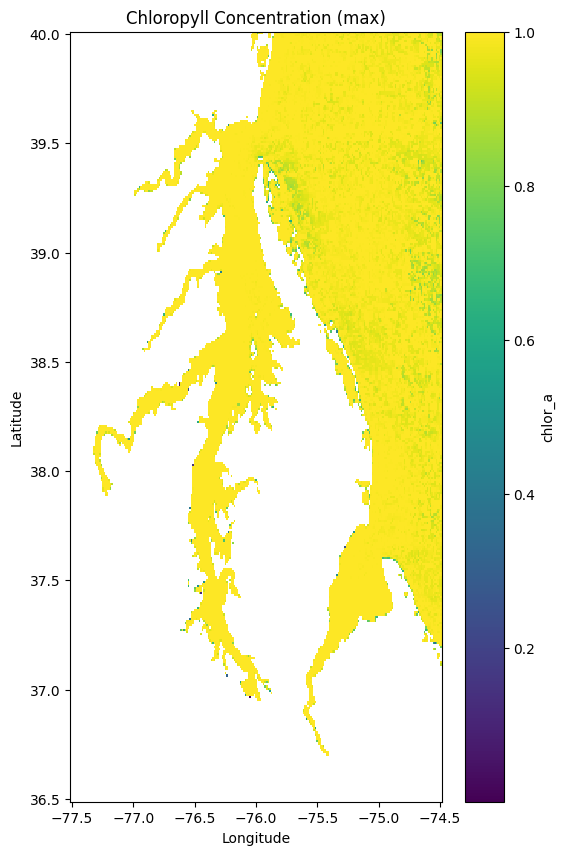

In [61]:
# Create a new figure for each variable
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = cleaned_data['chlor_a'].max(dim='time', skipna=True).isel(depth=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chloropyll Concentration (max)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## Dealing with missing values

In [28]:
cleaned_data = merged_data

cleaned_data['Wind_Direction_rad'] = np.deg2rad(cleaned_data['Wind Direction'])
cleaned_data['Wind_Direction_sin'] = np.sin(cleaned_data['Wind_Direction_rad'])
cleaned_data['Wind_Direction_cos'] = np.cos(cleaned_data['Wind_Direction_rad'])
# Interpolate along the time dimension
cleaned_data['Wind_Direction_sin'] = cleaned_data['Wind_Direction_sin'].interpolate_na(dim='time', method='linear')
cleaned_data['Wind_Direction_cos'] = cleaned_data['Wind_Direction_cos'].interpolate_na(dim='time', method='linear')
# Recalculate wind direction from interpolated sine and cosine, and adjust range to [0, 2π)
cleaned_data['Wind_Direction_interp_rad'] = np.arctan2(cleaned_data['Wind_Direction_sin'], cleaned_data['Wind_Direction_cos'])
cleaned_data['Wind_Direction_interp_rad'] = np.mod(cleaned_data['Wind_Direction_interp_rad'], 2 * np.pi)

# Replace original Wind Direction with interpolated values
cleaned_data['Wind Direction'] = cleaned_data['Wind_Direction_interp_rad']
# Drop intermediate variables if not needed
cleaned_data = cleaned_data.drop_vars(['Wind_Direction_rad', 'Wind_Direction_sin', 'Wind_Direction_cos', 'Wind_Direction_interp_rad'])

In [58]:
variables_linear = ['chlor_a', 'Air Temperature', 'Air pressure', 'Humidity', 'Wind speed']

for var in variables_linear:
    cleaned_data[var] = cleaned_data[var].interpolate_na(dim='time', method='linear')

In [59]:
cleaned_data

<xarray.Dataset> Size: 12GB
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 3kB 36.49 36.5 36.51 ... 39.99 40.0 40.01
  * lon              (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float64 2GB nan nan ... 0.08785
    Air Temperature  (time, depth, lat, lon) float64 2GB 0.4947 0.4947 ... 0.0
    Air pressure     (time, depth, lat, lon) float64 2GB 1.0 1.0 ... 0.283 0.283
    Humidity         (time, depth, lat, lon) float64 2GB 0.1298 0.1298 ... 0.294
    Wind speed       (time, depth, lat, lon) float64 2GB 0.1517 ... 0.6033
    Wind Direction   (time, depth, lat, lon) float64 2GB 0.6124 ... 0.9691

Finally, we normalize the data. We scale the weather data to be between 0 and 1. Let's check the statistics for the variables.

In [31]:
# List of features to normalize (excluding the target 'chlor_a')
variables_to_normalize = ['Air Temperature', 'Air pressure', 'Humidity', 'Wind speed', 'Wind Direction']

for var in variables_to_normalize:
    # Compute the min and max values across time, depth, lat, and lon
    var_min = cleaned_data[var].min(dim=('time', 'depth', 'lat', 'lon'))
    var_max = cleaned_data[var].max(dim=('time', 'depth', 'lat', 'lon'))

    # Apply min-max scaling
    cleaned_data[var] = (cleaned_data[var] - var_min) / (var_max - var_min)

We can also plot the chlorophyll values to determine the best way to scale the data.

(array([6.5787854e+07, 8.2225430e+06, 4.2403720e+06, 2.4393070e+06,
        1.5872200e+06, 1.1061350e+06, 7.8703200e+05, 5.5954300e+05,
        4.2393900e+05, 3.3673600e+05, 2.7689800e+05, 2.3518600e+05,
        2.0159900e+05, 1.7075400e+05, 1.4775100e+05, 1.2798900e+05,
        1.1202600e+05, 9.4237000e+04, 7.8815000e+04, 6.5300000e+04,
        5.2850000e+04, 4.1292000e+04, 3.0992000e+04, 2.2261000e+04,
        1.3919000e+04]),
 array([  0.        ,   8.2993269 ,  16.59865379,  24.89797974,
         33.19730759,  41.49663544,  49.79595947,  58.09528732,
         66.39461517,  74.69393921,  82.99327087,  91.29259491,
         99.59191895, 107.89125061, 116.19057465, 124.48989868,
        132.78923035, 141.08856201, 149.38787842, 157.68721008,
        165.98654175, 174.28585815, 182.58518982, 190.88452148,
        199.18383789, 207.48316956]),
 <BarContainer object of 25 artists>)

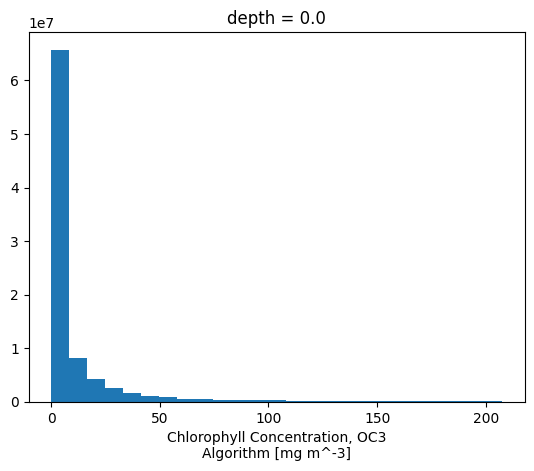

In [32]:
cleaned_data['chlor_a'].plot.hist(bins=25)

Trying a log transformation

(array([  98823., 2709133., 5818980., 5745360., 5186317., 4639108.,
        4412897., 4090371., 3694371., 3384319., 3119220., 2937149.,
        2796802., 2732229., 2647963., 2476601., 2248686., 2035341.,
        1871379., 1727287., 1602025., 1508094., 1438069., 1385208.,
        1340936., 1292600., 1254007., 1229547., 1195966., 1129796.,
        1041020.,  958526.,  880009.,  820727.,  750453.,  688938.,
         628159.,  554867.,  477124.,  411320.,  366612.,  327992.,
         298380.,  272796.,  241447.,  215303.,  184485.,  144341.,
          99404.,   52063.]),
 array([0.        , 0.10679717, 0.21359435, 0.32039151, 0.42718869,
        0.53398585, 0.64078301, 0.74758017, 0.85437739, 0.96117455,
        1.06797171, 1.17476892, 1.28156602, 1.38836324, 1.49516034,
        1.60195756, 1.70875478, 1.81555188, 1.9223491 , 2.02914619,
        2.13594341, 2.24274063, 2.34953785, 2.45633483, 2.56313205,
        2.66992927, 2.77672648, 2.8835237 , 2.99032068, 3.0971179 ,
        3.20391512

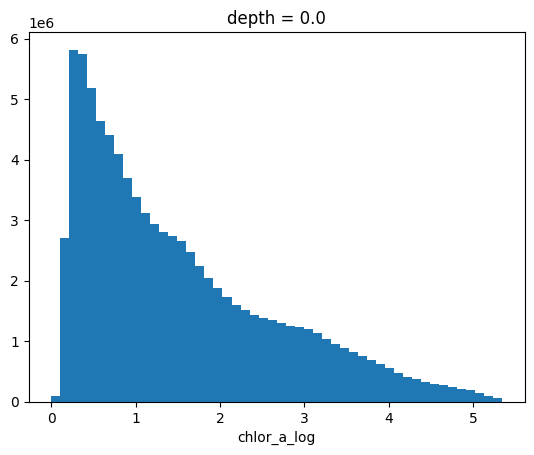

In [33]:
# Apply log transformation to chlor_a, adding 1 to avoid log(0)
cleaned_data['chlor_a_log'] = np.log(cleaned_data['chlor_a'] + 1)

# Check the distribution after the transformation
cleaned_data['chlor_a_log'].plot.hist(bins=50)

(array([1777886., 1682977., 1805522., 1748503., 1673642., 1636314.,
        1795174., 1650399., 1842474., 1633583., 1791935., 1669355.,
        1880403., 1576237., 2061843., 1561579., 1853666., 1678319.,
        1782510., 1761016., 1678820., 1760584., 1686530., 1611348.,
        1868893., 2031268., 1667140., 1691999., 1842702., 1427331.,
        1690423., 1764961., 1695780., 1802265., 1457156., 1698034.,
        1704178., 1799796., 1743670., 1749241., 1704440., 1671947.,
        1918237., 1892518., 1772737., 1586837., 1635792., 1948345.,
        2082400., 1713841.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

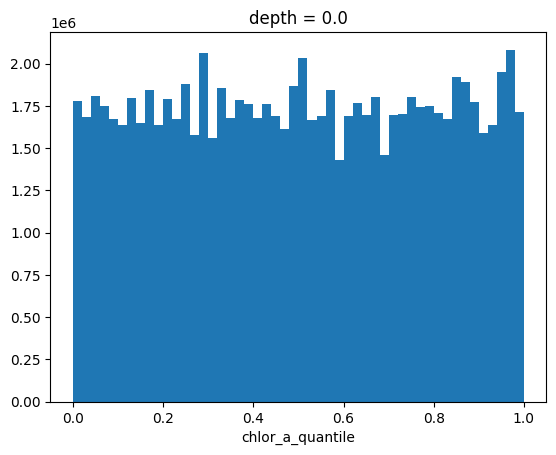

In [34]:
import numpy as np
from sklearn.preprocessing import QuantileTransformer

# Extract chlor_a values and flatten the data, remove NaN values
chlor_a_values = cleaned_data['chlor_a'].values.flatten()
chlor_a_values = chlor_a_values[~np.isnan(chlor_a_values)]  # Remove NaN values

# Reshape the data to a 2D array (required by QuantileTransformer)
chlor_a_values = chlor_a_values.reshape(-1, 1)

# Apply quantile transformation to map the data to a uniform distribution
quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=0)
chlor_a_quantile = quantile_transformer.fit_transform(chlor_a_values)

# Reshape the transformed data back to the original chlor_a shape
chlor_a_quantile_reshaped = np.full(cleaned_data['chlor_a'].shape, np.nan)
chlor_a_quantile_reshaped[~np.isnan(cleaned_data['chlor_a'].values)] = chlor_a_quantile.flatten()

# Add transformed data back into the xarray dataset
cleaned_data['chlor_a_quantile'] = (('time', 'depth', 'lat', 'lon'), chlor_a_quantile_reshaped)

cleaned_data['chlor_a_quantile'].plot.hist(bins=50)


In [35]:
cleaned_data['chlor_a'] = cleaned_data['chlor_a_quantile']
cleaned_data = cleaned_data.drop_vars(['chlor_a_quantile','chlor_a_log'])

In [36]:
cleaned_data

<xarray.Dataset> Size: 12GB
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 3kB 36.49 36.5 36.51 ... 39.99 40.0 40.01
  * lon              (lon) float64 2kB -77.51 -77.5 -77.49 ... -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float64 2GB nan nan ... 0.08785
    Air Temperature  (time, depth, lat, lon) float64 2GB 0.4947 0.4947 ... 0.0
    Air pressure     (time, depth, lat, lon) float64 2GB 1.0 1.0 ... 0.283 0.283
    Humidity         (time, depth, lat, lon) float64 2GB 0.1298 0.1298 ... 0.294
    Wind speed       (time, depth, lat, lon) float64 2GB 0.1517 ... 0.6033
    Wind Direction   (time, depth, lat, lon) float64 2GB 0.6124 ... 0.9691

In [38]:
cleaned_data.to_netcdf('../../data/satelliteBuoy_clean.nc4')

In [37]:
for var in cleaned_data.data_vars:
    data = cleaned_data[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")


Percentage of NaN values in 'chlor_a': 63.79%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Humidity': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values in 'Wind Direction': 0.00%


## Masking datasets with shape file

We only want to work with data from the Chesapeake Bay proper. Additionally, for latitude and longitude points corresponding to land instead of water, the chlorophyll value is always set to `-1`, which will create false correlations in the analysis.

These shape firls come from the EPA and Chesapeake Bay Foundation definitions of the 92 regions of the Chesapeake Bay Watershed, accessed via [ArcGIS Hub](https://hub.arcgis.com/datasets/ChesBay::chesapeake-bay-92-segments/about).

In [13]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.vectorized import contains
from pyproj import Transformer


Skipping the previous sections by reading in the file

In [ ]:
cleaned_data = xr.open_dataset('../../data/satelliteBuoy_clean.nc4')

And now the shape file.

In [14]:
shapefile_path = '../../data/shapeFiles/Chesapeake_Bay_92_Segments.shp'
gdf = gpd.read_file(shapefile_path).drop(columns=['OBJECTID'])

# Inspect the GeoDataFrame
print(gdf.head())

# Get the CRS of the polygon
polygon_crs = gdf.crs
print(polygon_crs)

  STATE     BasinGroup                  Name  CBSEG_92  \
0    DC        POTOMAC       Anacostia River  ANATF_DC   
1    MD        POTOMAC       Anacostia River  ANATF_MD   
2    VA          JAMES      Appomattox River     APPTF   
3    MD  PATAPSCO-BACK            Back River     BACOH   
4    MD       LOWER ES  Big Annemessex River     BIGMH   

                                            geometry  
0  POLYGON ((-8565111.288 4709935.421, -8565110.5...  
1  MULTIPOLYGON (((-8564979.652 4709911.163, -856...  
2  POLYGON ((-8606928.98 4482503.86, -8606922.232...  
3  POLYGON ((-8514017.911 4767829.07, -8514090.09...  
4  POLYGON ((-8434950.372 4593535.927, -8434909.6...  
EPSG:3857


Next, we will combine the shape files for the relevant regions: the Chesapeake Bay proper, which start with `CB`, Eastern Bay `EASMH`, Mobjack Bay `MOBPH`, and Tangier Sound `TANMH_MD` and `TANMH_VA`.

In [15]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'].astype(str).str.startswith('TANMH'))
]

combined_polygon = gpd.GeoSeries(filtered_gdf.geometry).union_all()

print(combined_polygon)

POLYGON ((-8507894.409755442 4503248.6013195515, -8507868.94049191 4503213.282092772, -8507813.761237614 4503203.062227152, -8507808.633904694 4503163.009569988, -8507879.121057276 4503147.717471801, -8507929.246079119 4503117.567678213, -8507878.30545204 4503041.558690175, -8507938.635739408 4502986.607137337, -8507863.857259272 4502920.757214531, -8507893.612750325 4502880.490855992, -8507994.653099084 4502870.104889303, -8507958.967769956 4502819.775866151, -8507979.389201079 4502789.1310693845, -8508150.04579683 4502778.947204001, -8508165.393495373 4502683.288689792, -8508210.403784376 4502653.216896713, -8508295.35512983 4502653.184796505, -8508381.109980445 4502612.695336528, -8508421.025436735 4502622.828801595, -8508446.51990043 4502693.53325557, -8508477.10489681 4502708.232949957, -8508497.435627349 4502643.147832058, -8508487.237961872 4502556.7274771705, -8508502.590560447 4502536.902849883, -8508577.319240266 4502607.170001052, -8508607.880536493 4502607.334702112, -85086

In [16]:
# Transform polygon to lat/lon coordinates
transformer_reverse = Transformer.from_crs("EPSG:3857", "epsg:4326", always_xy=True)

lat_lon_polygon = shapely.ops.transform(transformer_reverse.transform, combined_polygon)

In [17]:
# Extract x and y coordinates from the polygon's exterior
x, y = lat_lon_polygon.exterior.xy

# Find the range of x and y
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

print(f"Range of x (Longitude): {x_min} to {x_max}")
print(f"Range of y (Latitude): {y_min} to {y_max}")


Range of x (Longitude): -76.56941380700695 to -75.73461468945172
Range of y (Latitude): 36.907351828374516 to 39.60900009147974


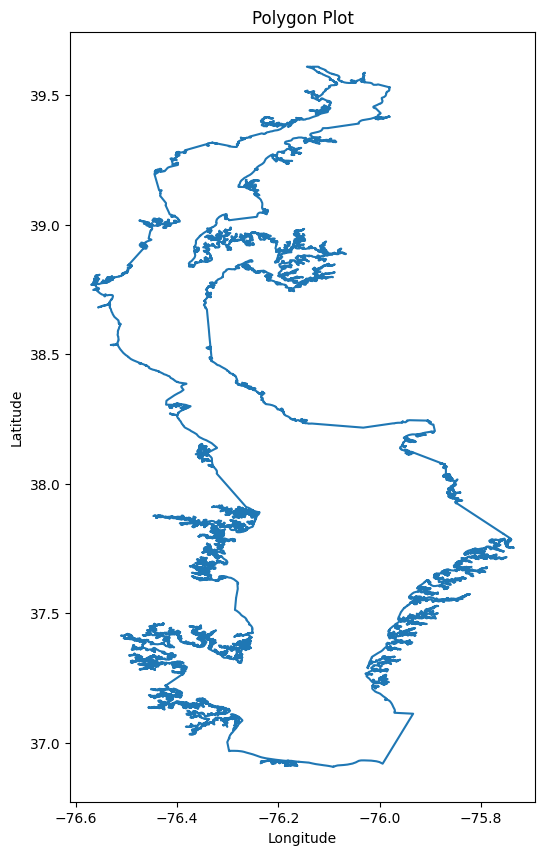

In [18]:
import matplotlib.pyplot as plt

# Adjust the figure size (width, height)
plt.figure(figsize=(6,10)) 

# Plot the polygon
x, y = lat_lon_polygon.exterior.xy
plt.plot(x, y)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygon Plot')

# Show the plot
plt.show()

Now we will create a latitude and longitude grid and use the polygon to restrict our data.

In [19]:
import numpy as np
import xarray as xr
from shapely.vectorized import contains
from tqdm import tqdm

def polygon_mask(ds, polygon):
    # Extract the lat/lon coordinates
    lon_coords = ds['lon'].values  # Longitude coordinates
    lat_coords = ds['lat'].values  # Latitude coordinates
    
    # Create a 2D grid from the 1D lat/lon arrays
    lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

    # Create a boolean mask using Shapely's vectorized contains method
    print("Creating polygon mask...")
    mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)

    # Convert the 2D mask to a DataArray with correct dimensions
    mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

    # Apply the mask to all data variables in the dataset
    print("Applying polygon mask...")
    masked_ds = ds.where(mask_expanded)  # This sets outside measurements to NaN]

    # Create a mask where all data variables are NaN across time, depth, and lon for each lat
    nan_mask_lat = masked_ds.isnull().all(dim=['depth', 'lon', 'time'])  # Check across depth, lon, and time
    nan_mask_lon = masked_ds.isnull().all(dim=['depth', 'lat', 'time'])  # Check across depth, lat, and time

    # Drop the lat coordinates where all data variables are NaN
    nan_mask = ~nan_mask_lat & ~nan_mask_lon  # Combine masks using logical AND
    masked_ds = masked_ds.where(nan_mask, drop=True)

    return masked_ds


In [52]:
def validate_masked_data(original_ds, masked_ds):

    # Create a set of spacial coordinates for masked_ds
    space_coords = set(zip(masked_ds['lat'].values, masked_ds['lon'].values))

    # Initialize mismatch count
    mismatch_count = 0  

    # Calculate total number of data points to validate
    total_data_points = len(masked_ds['time']) * len(space_coords) * len(masked_ds.data_vars)

    # Create a progress bar for the total data points
    with tqdm(total=total_data_points, desc="Validating masked data...") as pbar:
        for var in masked_ds.data_vars:
            original_values = original_ds[var].values  # Get original values
            masked_values = masked_ds[var].values  # Get masked values

            # Initialize mismatch count
            mismatch_count = 0

            # Iterate over time values
            for time_value in masked_ds['time'].values:
                for lat_value, lon_value in space_coords:
                    # Retrieve original and masked values based on coordinate values
                    original_value = original_ds[var].sel(time=time_value, depth=0, lat=lat_value, lon=lon_value).values
                    masked_value = masked_ds[var].sel(time=time_value, depth=0, lat=lat_value, lon=lon_value).values

                    # Check for equality
                    if not np.isnan(masked_value) and original_value != masked_value:
                        mismatch_count += 1
                        # Log the mismatch
                        print(f"Mismatch at time={time_value}, lat={lat_value}, lon={lon_value}.")
                        mismatch_count += 1

                    # Update the progress bar for each check processed
                    pbar.update(1)

            print(f"Variable '{var}' has {mismatch_count} mismatches.")

    print("Validation completed: All relationships preserved, ignoring NaN values.")


In [39]:
masked_xarray = polygon_mask(cleaned_data,lat_lon_polygon)

Creating polygon mask...
Applying polygon mask...


In [40]:
masked_xarray

<xarray.Dataset> Size: 2GB
Dimensions:          (time: 2767, depth: 1, lat: 273, lon: 66)
Coordinates:
  * time             (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-...
  * depth            (depth) float64 8B 0.0
  * lat              (lat) float64 2kB 36.91 36.92 36.93 ... 39.58 39.59 39.6
  * lon              (lon) float64 528B -76.56 -76.55 -76.54 ... -75.76 -75.75
Data variables:
    chlor_a          (time, depth, lat, lon) float64 399MB nan nan ... nan nan
    Air Temperature  (time, depth, lat, lon) float64 399MB nan nan ... nan nan
    Air pressure     (time, depth, lat, lon) float64 399MB nan nan ... nan nan
    Humidity         (time, depth, lat, lon) float64 399MB nan nan ... nan nan
    Wind speed       (time, depth, lat, lon) float64 399MB nan nan ... nan nan
    Wind Direction   (time, depth, lat, lon) float64 399MB nan nan ... nan nan

In [53]:
validate_masked_data(cleaned_data,masked_xarray)

Validating masked data...:  17%|█▋        | 182801/1095732 [02:51<16:29, 922.19it/s] 

Variable 'chlor_a' has 0 mismatches.


Validating masked data...:  33%|███▎      | 365416/1095732 [06:01<13:18, 914.20it/s] 

Variable 'Air Temperature' has 0 mismatches.


Validating masked data...:  50%|█████     | 548035/1095732 [09:06<08:36, 1060.18it/s]

Variable 'Air pressure' has 0 mismatches.


Validating masked data...:  67%|██████▋   | 730606/1095732 [12:10<05:20, 1139.60it/s]

Variable 'Humidity' has 0 mismatches.


Validating masked data...:  83%|████████▎ | 913264/1095732 [15:22<02:49, 1073.42it/s]

Variable 'Wind speed' has 0 mismatches.


Validating masked data...: 100%|██████████| 1095732/1095732 [18:27<00:00, 988.93it/s] 

Variable 'Wind Direction' has 0 mismatches.
Validation completed: All relationships preserved, ignoring NaN values.


In [43]:
for var in masked_xarray.data_vars:
    data = masked_xarray[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")


Percentage of NaN values in 'chlor_a': 88.81%
Percentage of NaN values in 'Air Temperature': 66.22%
Percentage of NaN values in 'Air pressure': 66.22%
Percentage of NaN values in 'Humidity': 66.22%
Percentage of NaN values in 'Wind speed': 66.22%
Percentage of NaN values in 'Wind Direction': 66.22%


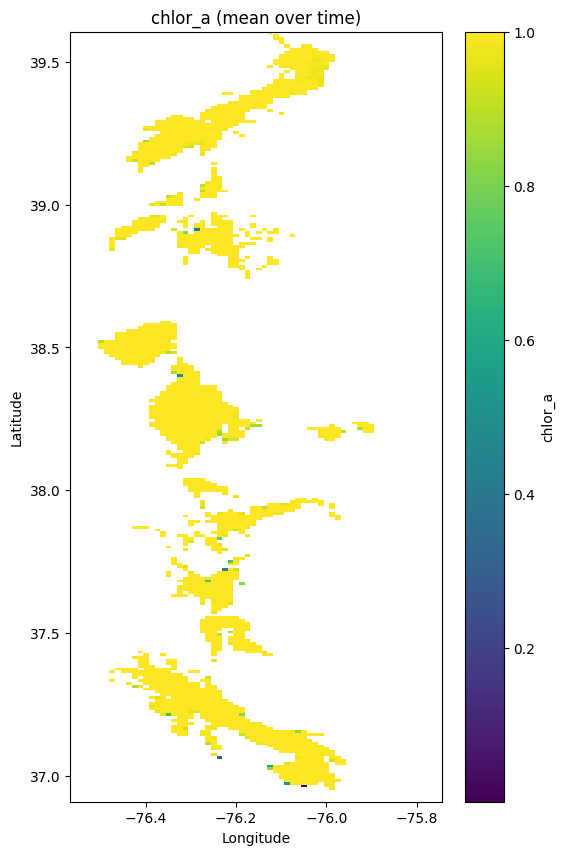

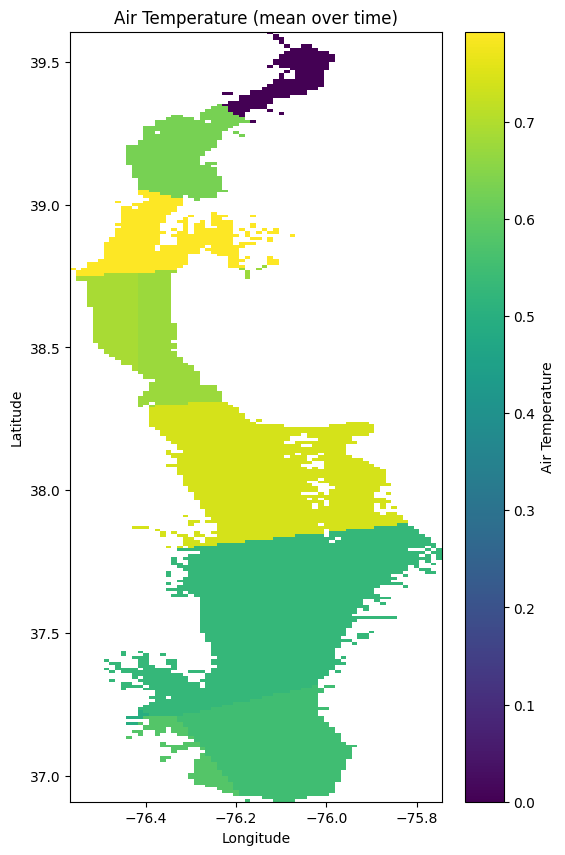

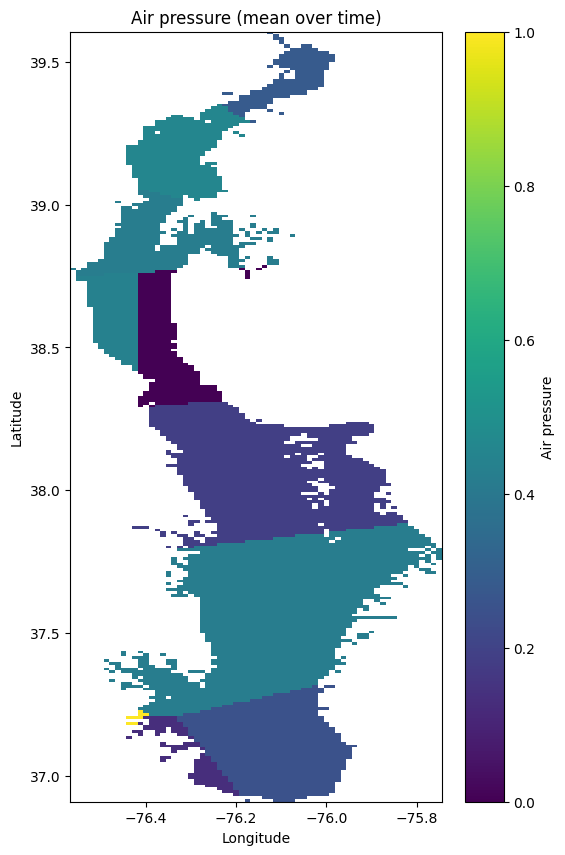

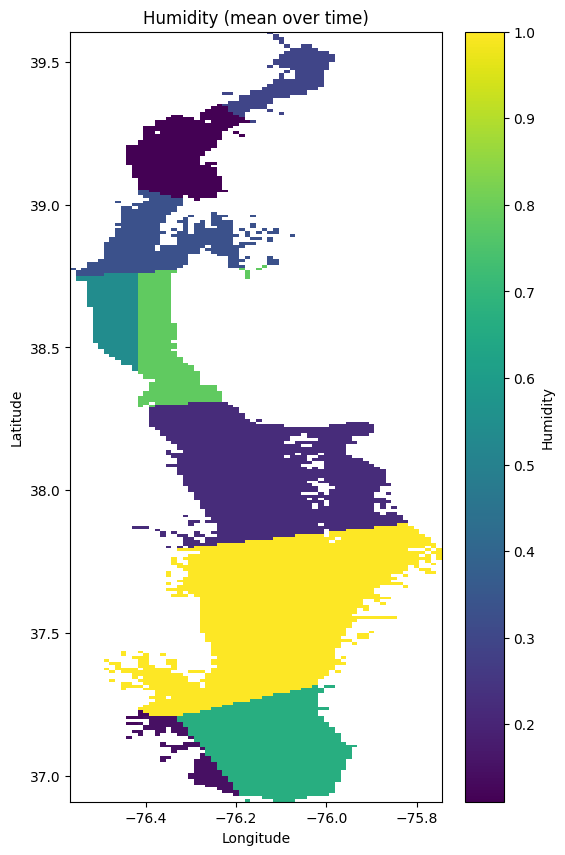

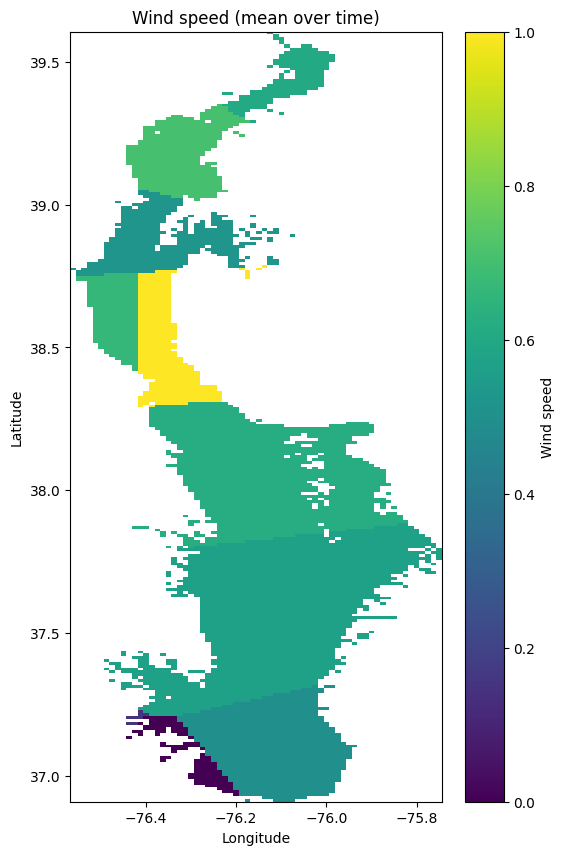

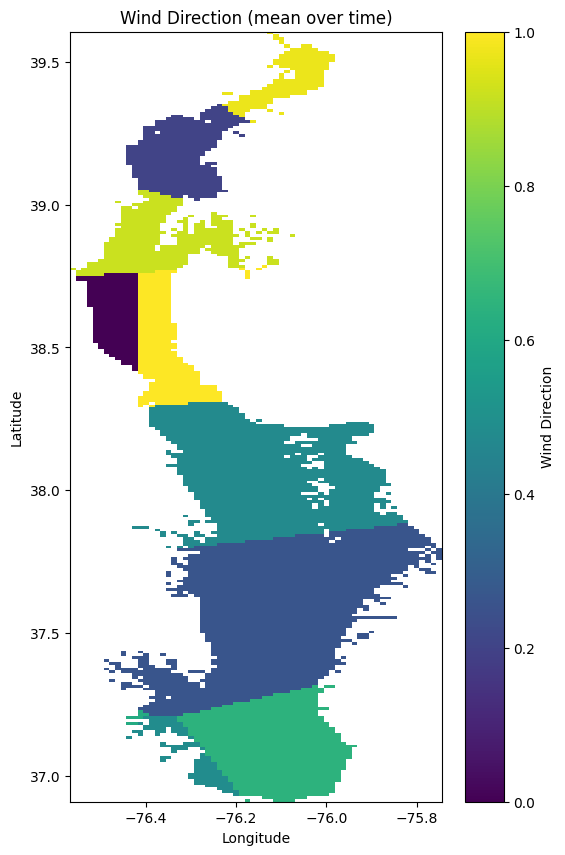

In [56]:
import matplotlib.pyplot as plt

# Loop through each data variable in the dataset
for variable in masked_xarray.data_vars:
    # Create a new figure for each variable
    plt.figure(figsize=(6, 10))
    
    # Calculate the mean across the time dimension for the current variable
    variable_mean = masked_xarray[variable].max(dim='time', skipna=True).isel(depth=0)
    
    # Plot the variable using xarray
    variable_mean.plot(cmap='viridis')
    
    # Add labels and title
    plt.title(f'{variable} (mean over time)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Show the plot
    plt.show()

